<a href="https://www.kaggle.com/code/evelynartoria/solving-mnist-with-vit-from-scratch-pytorch?scriptVersionId=189784440" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![vision transformer architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png)

In [1]:
from typing import Tuple
import matplotlib.pyplot as plt
from dataclasses import dataclass

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
from tqdm import tqdm

2024-07-25 21:29:58.707897: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 21:29:58.708009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 21:29:58.838309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"default device set to {device}")

default device set to cuda


In [3]:
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

In [4]:
class MNIST(Dataset):
    def __init__(self, df: pd.DataFrame, scaler: object, train: bool = True):
        self.dataset = df
        self.train = train
        
        if train:
            self.inputs = scaler.fit_transform(df.drop(columns=["label"]).to_numpy())
        else:
            self.inputs = scaler.fit_transform(df.to_numpy())
            
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        inputs = torch.tensor(self.inputs[idx].reshape(1, 28, 28), dtype=torch.float32)
        if self.train:
            label = torch.tensor(self.dataset["label"].iloc[idx], dtype=torch.long)
            return (inputs, label)
        else:
            return inputs

In [5]:
train_split, val_split = train_test_split(train_df, test_size=0.1, shuffle=True)

In [6]:
scaler = StandardScaler()
train_dataset = MNIST(df=train_split, train=True, scaler=scaler)
val_dataset = MNIST(df=val_split, train=True, scaler=scaler)

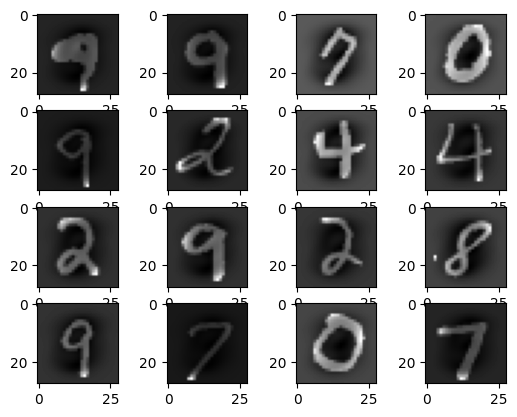

In [7]:
# the visualization is based on the scaled images
def plot_random_data(dataset: Dataset, num_samples: Tuple[int, int]):
    fig, axis = plt.subplots(num_samples[0], num_samples[1])
    random_image_idx = torch.randint(0, len(dataset), (num_samples[0], num_samples[1],))
    for x in range(num_samples[0]):
        for y in range(num_samples[1]):
            axis[x][y].imshow(dataset[random_image_idx[x][y].item()][0].cpu().numpy().reshape(28, 28, 1), cmap="gray")

plot_random_data(dataset=train_dataset, num_samples=(4, 4))

# All hyperparamters

In [8]:
@dataclass
class ViTConfig:
    n_embd: int = 768
    patch_size: Tuple[int, int] = (12, 12)
    img_size: Tuple[int, int] = (28, 28)
    in_channels: int = 1
    n_layers: int = 10
    n_heads: int = 12
    head_size: int = None
    qvk_bias: bool = False
    dropout: float = 0.05
    mlp_ratio: float = 4.0
    n_classes: int = 10
    
    def __post_init__(self):
        if self.head_size is None:
            self.head_size = self.n_embd//self.n_heads

In [9]:
class AttentionHead(nn.Module):
    def __init__(self, n_embd: int, head_size: int, qvk_bias: bool, dropout: float):
        super(AttentionHead, self).__init__()
        
        self.Q = nn.Linear(in_features=n_embd, out_features=head_size, bias=qvk_bias)
        self.K = nn.Linear(in_features=n_embd, out_features=head_size, bias=qvk_bias)
        self.V = nn.Linear(in_features=n_embd, out_features=head_size, bias=qvk_bias)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        q = self.Q(x) # (B, n_patches + 1, n_embd) @ (B, n_embd, head_size) --> (B, n_patches + 1, head_size)
        k = self.K(x) # (B, n_patches + 1, n_embd) @ (B, n_embd, head_size) --> (B, n_patches + 1, head_size)
        v = self.V(x) # (B, n_patches + 1, n_embd) @ (B, n_embd, head_size) --> (B, n_patches + 1, head_size)
        
        attention = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5) # (B, n_patches + 1, head_size) @ (B, head_size, n_patches + 1) --> (B, n_patches + 1, n_patches +1)
        attention = self.dropout(attention) # dropout some of the attention scores; very important to do so before masked fill ou softmax and not right after
        if mask is not None:
            attention = attention.masked_fill(mask==0, float('-inf'))
            
        attention = torch.softmax(attention, dim=-1)
        
        x = attention @ v # (B, n_patches + 1, n_patches + 1) @ (B, n_patches + 1, head_size) -->  (B, n_patches + 1, head_size)
        return x

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_embd: int, n_heads: int, head_size: int, qvk_bias: bool, dropout: float):
        super(MultiHeadedAttention, self).__init__()
        
        self.sa_heads = nn.ModuleList([AttentionHead(n_embd=n_embd, head_size=head_size, qvk_bias=qvk_bias, dropout=dropout) for _ in range(n_heads)])
        self.dropout = nn.Dropout(dropout)
        self.projection = nn.Linear(in_features=head_size * n_heads, out_features=n_embd)
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        x = torch.cat([head(x) for head in self.sa_heads], dim=-1) # (B, n_patches + 1, n_heads * head_size)
        return self.projection(self.dropout(x)) # (B, n_patches + 1, n_heads * head_size) @ (B, n_heads * head_size, n_embd) --> (B, n_patches + 1, n_embd)


In [11]:
class MLP(nn.Module):
    def __init__(self, in_features: int, out_features: int, hidden_size: int, dropout: float):
        super(MLP, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=hidden_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=hidden_size, out_features=out_features),
            nn.Dropout(dropout)
        )
        # assuming n_embd == in_features
        # linear1 --> x (B, n_patches + 1, n_embd) @ (B, in_features, hidden_size) --> (B, n_patches + 1, hidden_size)
        # linear2 --> (B, n_patches + 1, hidden_size) @ (B, hidden_size, out_features) --> (B, n_patches + 1, out_features)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, n_embd: int, n_heads: int, head_size: int, qvk_bias: bool, mlp_ratio: float, dropout: float):
        super(EncoderBlock, self).__init__()
        self.multihead_attention = MultiHeadedAttention(n_embd=n_embd, n_heads=n_heads, head_size=head_size, qvk_bias=qvk_bias, dropout=dropout)
        self.mlp = MLP(in_features=n_embd, out_features=n_embd, hidden_size=int(mlp_ratio*n_embd), dropout=dropout)
        self.layernorm1 = nn.LayerNorm(n_embd)
        self.layernorm2 = nn.LayerNorm(n_embd)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        x = x + self.dropout(self.multihead_attention(self.layernorm1(x))) # (B, n_patches + 1, n_embd)
        x = x + self.dropout(self.mlp(self.layernorm2(x))) # (B,n_patches + 1, n_embd)
        return x

In [13]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size: Tuple[int, int], patch_size: Tuple[int, int], in_channels: int, n_embd: int):
        super(PatchEmbedding, self).__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_embd = n_embd
        self.n_patches = img_size[0]//patch_size[0] * img_size[1]//patch_size[1]
        
        # #the conv2d layer filter is going to move patch_size pixels horizontally and vertically because of the stride being set to patch_size (they do not overlap)
        # for example, assuming patch_size as 4x4, and an image of shape 16x16, there would be 256 pixels, divided by patches of 16 pixels each, so 16 patches total 
        self.projection = nn.Conv2d(
            in_channels=in_channels, kernel_size=patch_size, 
            stride=patch_size, out_channels=n_embd
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x of shape B, C, W, H
        x = self.projection(x) # # (B, n_embd, sqrt(n_patches), sqrt(n_patches)) --> sqrt(n_patches) * sqrt(n_patches) = n_patches (basically n_embd channels with sqrt(n_patches) each)
        x = x.view(x.shape[0], self.n_embd, -1) #(B, n_embd, n_patches)
        return x.transpose(1, 2) # (B, n_embd, n_patches)

In [14]:
class ViT(nn.Module):
    def __init__(self, config: ViTConfig):
        super(ViT, self).__init__()
        self.config = config
        self.patch_embedding = PatchEmbedding(
            img_size=config.img_size, patch_size=config.patch_size, 
            n_embd=config.n_embd, in_channels=config.in_channels
        )
        self.cls_token = nn.Parameter(torch.zeros(size=(1, 1, config.n_embd)))
        self.pos_embedding = nn.Parameter(torch.zeros(size=(1, self.patch_embedding.n_patches+1, config.n_embd))) # information about the position of the current patch
        self.blocks = nn.ModuleList([EncoderBlock(n_embd=config.n_embd, n_heads=config.n_heads, head_size=config.head_size, qvk_bias=config.qvk_bias, mlp_ratio=config.mlp_ratio, dropout=config.dropout) for _ in range(config.n_layers)])
        self.dropout = nn.Dropout(config.dropout)
        self.layernorm = nn.LayerNorm(config.n_embd)
        self.classifier = nn.Linear(in_features=config.n_embd, out_features=config.n_classes)
        
    def forward(self, x: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        B = x.shape[0]
        cls_token = self.cls_token.expand(B, -1, -1) # (B, 1, n_embd)
        x = self.patch_embedding(x) # (B, n_patches, n_embd)
        x = torch.cat([cls_token, x], dim=1) # cat along the n_patches dim --> (B, n_patches + 1, n_embd); cls_token added is at (:, 0, :)
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        for block in self.blocks:
            x = block(x, mask) # (B, n_patches+1, n_embd)
            
        x = self.layernorm(x)
        
        cls_token_representation = x[:, 0, :] # select the class_token
        x = self.classifier(cls_token_representation) # (B, n_embd) @ (n_embd, n_classes) --> (B, n_classes)
        return x

In [15]:
vit_config = ViTConfig()
vit = ViT(config=vit_config)
vit.config

ViTConfig(n_embd=768, patch_size=(12, 12), img_size=(28, 28), in_channels=1, n_layers=10, n_heads=12, head_size=64, qvk_bias=False, dropout=0.05, mlp_ratio=4.0, n_classes=10)

In [16]:
val_dataloader = DataLoader(dataset=val_dataset, batch_size=4, generator=torch.Generator(device=device))
vit.eval()
with torch.inference_mode():
    batch_images, batch_labels = next(iter(val_dataloader))
    logits = vit(batch_images)
    print(logits.shape)
    print(batch_labels.shape)

torch.Size([4, 10])
torch.Size([4])


In [17]:
def fit(model, train_dataloader, loss_fn, optimizer, current_epoch, writer):
    model.train()
    for batch_idx, (batch_inputs, batch_labels) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        logits = model(batch_inputs) # (B, n_classes)
        loss = loss_fn(logits, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10000 == 0:
            print(f"loss for batch {batch_idx+1} --> {loss} at epoch {current_epoch+1}")

        writer.add_scalar("Train loss", loss, batch_idx)



In [18]:
def validate(model, val_dataloader, current_epoch, writer):
    model.eval()
    total_correct = 0
    total_inputs = 0

    with torch.inference_mode():
        for batch_inputs, batch_labels in tqdm(val_dataloader, total=len(val_dataloader)):
            logits = model(batch_inputs) # (B, n_classes)
            percents = torch.softmax(logits, dim=1) # (B, n_classes)
            preds = torch.argmax(logits, dim=1) # (B)
            total_correct += (preds == batch_labels).sum().item()
            total_inputs += batch_labels.shape[0]
        acc = total_correct/total_inputs * 100

        print(f"acc of {acc} --> {total_correct} out of {total_inputs}")

    writer.add_scalar("Val acc", acc, current_epoch)

In [19]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, scheduler, epochs, val_first: bool = True):
    writer = SummaryWriter()
    writer.add_graph(model, torch.zeros(size=(1, 1, 28, 28), dtype=torch.float32))
    match val_first:
        case True:
            for epoch in range(epochs):
                validate(model=model, val_dataloader=val_dataloader, current_epoch=epoch, writer=writer)
                fit(model=model, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, current_epoch=epoch, writer=writer)
                scheduler.step()
        case False:
            for epoch in range(epochs):
                fit(model=model, train_dataloader=train_dataloader, loss_fn=loss_fn, optimizer=optimizer, current_epoch=epoch, writer=writer)
                validate(model=model, val_dataloader=val_dataloader, current_epoch=epoch, writer=writer)
                scheduler.step()


    writer.close()



In [20]:
optimizer = torch.optim.AdamW(params=vit.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer=optimizer, gamma=0.9, step_size=3)

In [21]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1024, generator=torch.Generator(device=device))
val_dataloader = DataLoader(dataset=val_dataset, batch_size=512, generator=torch.Generator(device=device))
train_model(model=vit, train_dataloader=train_dataloader, val_dataloader=val_dataloader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, epochs=15, val_first=True)

100%|██████████| 9/9 [00:01<00:00,  6.76it/s]


acc of 17.5 --> 735 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.33it/s]


acc of 89.71428571428571 --> 3768 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.37it/s]


acc of 94.14285714285714 --> 3954 out of 4200


100%|██████████| 9/9 [00:01<00:00,  7.37it/s]


acc of 95.11904761904762 --> 3995 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.34it/s]


acc of 95.76190476190476 --> 4022 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.42it/s]


acc of 96.07142857142857 --> 4035 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.21it/s]


acc of 95.83333333333334 --> 4025 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.39it/s]


acc of 95.83333333333334 --> 4025 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.48it/s]


acc of 96.04761904761905 --> 4034 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.36it/s]


acc of 97.02380952380952 --> 4075 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.26it/s]


acc of 97.14285714285714 --> 4080 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.39it/s]


acc of 97.02380952380952 --> 4075 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.36it/s]


acc of 97.09523809523809 --> 4078 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.47it/s]


acc of 97.33333333333334 --> 4088 out of 4200


100%|██████████| 9/9 [00:00<00:00,  9.03it/s]


acc of 97.02380952380952 --> 4075 out of 4200


100%|██████████| 37/37 [00:21<00:00,  1.70it/s]


In [22]:
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_dataset = MNIST(df=test_df, scaler=StandardScaler(), train=False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=512, generator=torch.Generator(device=device), shuffle=False)

In [23]:
df = {
    "ImageId": [],
    "Label": []

}
total = 0
for batch_idx, batch_inputs in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    logits = vit(batch_inputs) # (B, n_classes)
    percents = torch.softmax(logits, dim=1) # (B, n_classes)
    preds = torch.argmax(logits, dim=1) # (B)
    total += logits.size(0)
    for ids, pred in enumerate(preds):
        df["Label"].append(pred.cpu().item())
        #df["ImageId"].append((batch_idx+1))
        
df["ImageId"] = [i+1 for i in range(total)]
df = pd.DataFrame(df)
df.to_csv("/kaggle/working/submission.csv", index=False)
df

100%|██████████| 55/55 [00:05<00:00,  9.62it/s]


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [24]:
print(df["Label"])

0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64
